# Technical Work Sample
## Coursework from Machine Learning in Statistics, Johns Hopkins University, Fall 2022
By Megan Waldo

### Example: How to apply two different algorithms to predict the median income from a California housing data set

### Step 1: Import necessary libraries and tools

In [1]:
# Import Libraries

import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"


import numpy as np
import pandas as pd
import os
import tarfile # For Housing Data Set
import urllib # For Housing Data Set

# Plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Save figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

np.random.seed(42)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# Import Tools

from sklearn import datasets 
    # to import data set

from sklearn.model_selection import train_test_split 
    # Split arrays or matrices into random train and test subsets.
    # Quick utility that wraps input validation and next(ShuffleSplit().split(X, y)) and application to input data into a single call for splitting (and optionally subsampling) data in a oneliner.
    # example in MNIST 1 

# for creating a stratified sample
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import StratifiedShuffleSplit  
 
from sklearn.impute import SimpleImputer
    # impute missing values in a df
from sklearn.pipeline import Pipeline
    # for creating pipelines while performing data transformations on a df
from sklearn.compose import ColumnTransformer
    # transform feature data types
from sklearn.base import clone 
    # to clone data frames
from sklearn.preprocessing import StandardScaler
    # Feature scaling
from sklearn.preprocessing import OneHotEncoder
    # Put variables in an array for doing data transformations
from sklearn.preprocessing import PolynomialFeatures 
    # Use for creating polynomial variables

from sklearn.metrics import confusion_matrix 
    # get confusion matrix of TP, FP, FN, and TN
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
    # get RMSE

# Get different types of classifier/regression algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import SGDClassifier
# types of regression algorithms - random forest is one too for ensemble learning (v powerful)
    # include random_state parameter if algorithm requires randomness
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
    # to run stochastic gradient descent on a linear regression

from sklearn.model_selection import cross_val_score 
    # to get accuracy score
from sklearn.model_selection import cross_val_predict 
    # to predict 
    # use after creating stratified sample 

### Step 2: Import the CA housing dataset 

The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

A household is a group of people residing within a home. Since the average number of rooms and bedrooms in this dataset are provided per household, these columns may take surprisingly large values for block groups with few households and many empty houses, such as vacation resorts.


In [3]:
# CA Housing Data Set

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Load housing data
housing = load_housing_data()


### Step 3: Explore, define and summarize the data frame

In [4]:
# Describe the data types of each feature in the df
housing.info()

# Describe range of values in each feature
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
# Check for missing values
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head(1000)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


In [7]:
# Check for correlation between the target variable (median_house_value) and other features
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

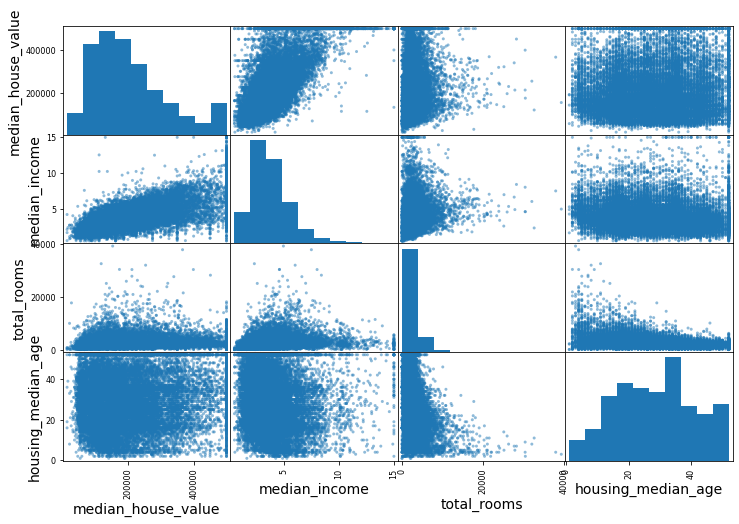

In [8]:
# View the correlation matrix for median_house_value, median_income, total_rooms and housing_median_age
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.savefig("scatter_matrix_plot.png")

### Data Frame Summary

1. Missing Data (Non-Null Count Differences)
    - Column 4, total_bedrooms has a Non-Null Count=20,433. 
    - The rest of the variables' counts are 20,640 (N).
    - The variable "total_bedrooms" has missing values.
    - This means that the "total_bedrooms" variable will require imputation before using an algorithm to predict the median price
    
    
2. Datatype Differences (Dtype Differences)
    - Column 8, ocean_proximity's datatype is an object (in characters).
    - The rest of the variables are float64 (numeric).
    - The "ocean_proximity" variable will need to be transformed into a numeric code before applying an algorithm


3. Datatype Correlation (Dtype Correlation)
   - median_income is correlated the highest with the median_house_value
   

### Step 4: Split the data into training and testing sets

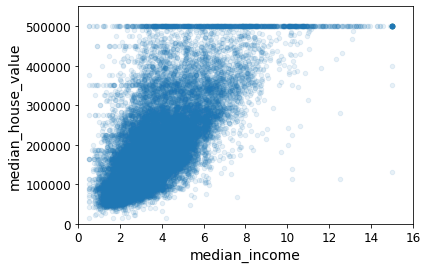

In [9]:
# Median_house_value is highly correlated with median_income
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.savefig("income_vs_house_value_scatterplot.png")


A couple things to take away from the plot above: 
- The price cap is clearly visible as a horizontal line at $500,000
- This indicates that censored values above that price cap may worsen our prediction of median_income if they are left in the dataframe before it is split for training and testing

In [10]:
# Drop censored values to make for a better prediction
housing.drop(housing[(housing["median_house_value"] == 500001)].index, axis=0, inplace=True)

housing = housing.reset_index(drop=True)

housing


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
19670,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
19671,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
19672,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
19673,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


We now have a data frame of 19,675 observations instead of 20,640. From here, we can create a train and test set:

In [11]:
# Split data into train and test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
test_set.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
16286,-122.28,37.50,33.0,6499.0,998.0,2694.0,957.0,7.4787,431300.0,NEAR OCEAN
7501,-118.08,33.90,42.0,1768.0,372.0,1155.0,368.0,3.5580,161100.0,<1H OCEAN
9416,-122.28,38.29,19.0,531.0,112.0,139.0,80.0,1.9875,325000.0,NEAR BAY
5385,-118.26,33.78,36.0,2191.0,739.0,2931.0,692.0,2.1311,163100.0,NEAR OCEAN
9910,-117.67,33.56,4.0,3289.0,728.0,1345.0,632.0,4.6863,184400.0,<1H OCEAN


Because median_income is highly correlated with median_house_value we need to redistribute the income category across the test set so that it is representative of variable from the whole dataset.

In [13]:
# We want to divide by 1.5 to limit the number of income categories. Ceiling rounds up the numbers 
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [17]:
# View new median_income categories: 
housing["income_cat"].value_counts() 

3.0    7103
2.0    6552
4.0    3502
5.0    1704
1.0     814
Name: income_cat, dtype: int64

<AxesSubplot:>

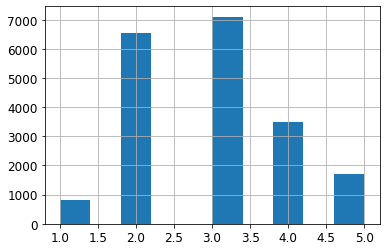

In [19]:
# Income transformation plot - shows the now normalized (bell-shaped) curve
housing["income_cat"].hist()

In [20]:
# Run Stratified Sampling
from sklearn.model_selection import StratifiedShuffleSplit

# 80/20 with a single splint. Random generate is 42. 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Create two datasets by splitting the housing data stratified by housing["income_cat"]
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.reindex(train_index)
    strat_test_set = housing.reindex(test_index)

In [21]:
train_index

array([   38, 17797,  4783, ...,  3566, 10631,  9223])

In [22]:
# Create x and y datasets for regression
housing = train_set.drop("median_income", axis=1) 
    # example of dropping variables in Week 2
housing_labels = train_set["median_income"].copy()



In [23]:
# Reset the index
housing = housing.reset_index(drop=True)

housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value,ocean_proximity
0,-120.50,37.34,16.0,1245.0,231.0,956.0,219.0,108000.0,INLAND
1,-119.81,36.77,43.0,2341.0,395.0,890.0,375.0,85000.0,INLAND
2,-118.49,34.42,23.0,4166.0,756.0,2082.0,743.0,213400.0,<1H OCEAN
3,-121.30,38.70,18.0,7334.0,1332.0,3339.0,1271.0,124700.0,INLAND
4,-121.04,37.50,33.0,613.0,123.0,343.0,116.0,129200.0,INLAND
...,...,...,...,...,...,...,...,...,...
15735,-121.08,40.19,11.0,919.0,199.0,69.0,43.0,137500.0,INLAND
15736,-121.48,38.56,52.0,814.0,216.0,327.0,181.0,125000.0,INLAND
15737,-118.27,33.77,39.0,1731.0,485.0,2115.0,478.0,141300.0,NEAR OCEAN
15738,-121.93,37.49,5.0,1150.0,311.0,648.0,245.0,300000.0,<1H OCEAN


In [24]:
# x variables in training set
housing.shape

(15740, 9)

In [25]:
# y variables in training set
housing_labels.shape 

(15740,)

In [26]:
# Drop income_cat to return data to original dataset
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [27]:
# reset the index
housing = housing.reset_index(drop=True)

housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value,ocean_proximity
0,-120.50,37.34,16.0,1245.0,231.0,956.0,219.0,108000.0,INLAND
1,-119.81,36.77,43.0,2341.0,395.0,890.0,375.0,85000.0,INLAND
2,-118.49,34.42,23.0,4166.0,756.0,2082.0,743.0,213400.0,<1H OCEAN
3,-121.30,38.70,18.0,7334.0,1332.0,3339.0,1271.0,124700.0,INLAND
4,-121.04,37.50,33.0,613.0,123.0,343.0,116.0,129200.0,INLAND
...,...,...,...,...,...,...,...,...,...
15735,-121.08,40.19,11.0,919.0,199.0,69.0,43.0,137500.0,INLAND
15736,-121.48,38.56,52.0,814.0,216.0,327.0,181.0,125000.0,INLAND
15737,-118.27,33.77,39.0,1731.0,485.0,2115.0,478.0,141300.0,NEAR OCEAN
15738,-121.93,37.49,5.0,1150.0,311.0,648.0,245.0,300000.0,<1H OCEAN


In [28]:
housing = strat_train_set.copy()

### Step 5: Transform rooms, bedrooms and population to percentages of household, room and population

In [30]:
# Transform variables of "rooms" or "bedrooms" into more useful information such as rooms per household
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Step 6: Prep data for regression algorithm

In [31]:
# drop labels for training set
housing = strat_train_set.drop("median_house_value", axis=1) 

housing_labels = strat_train_set["median_house_value"].copy()

In [32]:
# Remove object feature from training set so we can rebuild a binary feature for it instead
housing_num = housing.drop('ocean_proximity', axis=1)

In [33]:
# Pipeline 1: Address null values in bedroom feature and scale data

# Build pipeline to both impute (the median) and scale the data features all in one step
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),

        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [34]:
# Pipeline 2 - Full pipeline to preprocess numerical and categorical variables

from sklearn.compose import ColumnTransformer


num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [35]:
# final prepared data
housing_prepared

array([[-1.34009174,  1.01157329,  1.8827453 , ...,  0.        ,
         1.        ,  0.        ],
       [-1.36997407,  2.28691739, -1.07211871, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.65206347, -0.76646117,  1.48343935, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.53253416, -0.66406128, -0.19364563, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82637705, -0.84558836, -0.27350682, ...,  0.        ,
         0.        ,  0.        ],
       [-1.02632729,  0.4716466 ,  0.44524389, ...,  0.        ,
         0.        ,  0.        ]])

### Step 7: Apply 2 different algorithms to predict median_income, then compare RMSE to determine the better method of prediction.

#### Algorithm 1: Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

# Fit linear regression
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [38]:
# Get the Root Mean Squared Error (RMSE) Score

from sklearn.model_selection import cross_val_score

# Select cross validation with 10 folds
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)


In [39]:
lin_rmse_scores.mean()

61284.465211323404

The linear model's RMSE is 61,284. The lower the RMSE is, the better the model is at predicting accurately. Let's compare this RMSE to the RMSE of a different algorithm now.

#### Algorithm 2: Random Forest Regressor

In [40]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [41]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse


16868.34876453883

In [42]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
    

In [43]:
forest_rmse_scores.mean()

45606.849682877866

The random forest model's RMSE is 45,606, which is less than the linear regression model we tried first. Based on the RMSE alone, we may think the Random Forest regressor is more accurate in predicting the median_income than the linear regression.